# Exploratory Analysis 🗺️ 📈 

In [2]:
import pandas as pd
pd.plotting.register_matplotlib_converters()
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

In [3]:
import random
# Get random arr, nsr and chf data
'''
arr: 1 - 96
chf: 97 = 126
nsr: 127 = 162
'''

#function to generate random number between two numbers
def rand_num(a, b):
    return int((b - a) * random.random() + a)


def get_random_samples():
    arr_n, chf_n, nsr_n = rand_num(1, 96), rand_num(97, 126), rand_num(127, 162)
    assert arr_n >= 1 and arr_n <= 96
    assert chf_n >= 97 and chf_n <= 126
    assert nsr_n >= 127 and nsr_n <= 162
    
    return arr_n, chf_n, nsr_n
    
arr_n, chf_n, nsr_n = get_random_samples()
print(f"arr: {arr_n}, chf: {chf_n}, nsr: {nsr_n}")


signal_arr = pd.read_csv(f"raw_data/{arr_n}_signal.csv")
signal_chf = pd.read_csv(f"raw_data/{chf_n}_signal.csv")
signal_nsr = pd.read_csv(f"raw_data/{nsr_n}_signal.csv")

#get second round of samples
arr_n, chf_n, nsr_n = get_random_samples()
signal_arr_2 = pd.read_csv(f"raw_data/{arr_n}_signal.csv")
signal_chf_2 = pd.read_csv(f"raw_data/{chf_n}_signal.csv")
signal_nsr_2 = pd.read_csv(f"raw_data/{nsr_n}_signal.csv")



signal_arr.head()

arr: 67, chf: 100, nsr: 140


,Time,SignalData
0,1 sec,-0.210819
1,2 sec,-0.333038
2,3 sec,-0.299596
3,4 sec,-0.298826
4,5 sec,-0.302348


In [4]:
def plot_signal(signal, signal_2, title):
    plt.figure(figsize=(14, 4))
    #plt.plot(signal[0:3000])
    plt.plot(signal[0:1000])
    #plt.plot(signal_2)
    plt.title(title)
    plt.xlabel("Seconds")


In [5]:
def apply_filters(data, fns=[]):
    for f in fns:
        data = f(data)
    return data

In [6]:
def plot_all_data(fns=[]):
    if len(fns) > 0:
        for sig, sig_2, title in [
            (apply_filters(signal_arr.SignalData, fns), apply_filters(signal_arr_2.SignalData, fns), "ARR"), 
            (apply_filters(signal_nsr.SignalData, fns), apply_filters(signal_nsr_2.SignalData, fns), "NSR"), 
            (apply_filters(signal_chf.SignalData, fns), apply_filters(signal_chf_2.SignalData, fns), "CHF")
        ]:
            plot_signal(sig, sig_2, title)
    else:
        for sig, sig_2, title in [
            (signal_arr.SignalData, signal_arr_2.SignalData, "ARR"), 
            (signal_nsr.SignalData, signal_nsr_2.SignalData, "NSR"), 
            (signal_chf.SignalData, signal_chf_2.SignalData, "CHF")
        ]:
            plot_signal(sig, sig_2, title)       

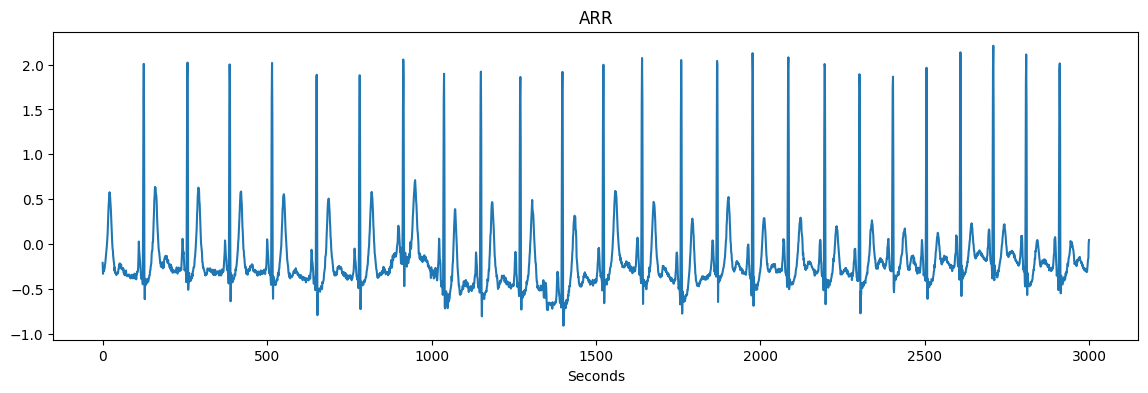

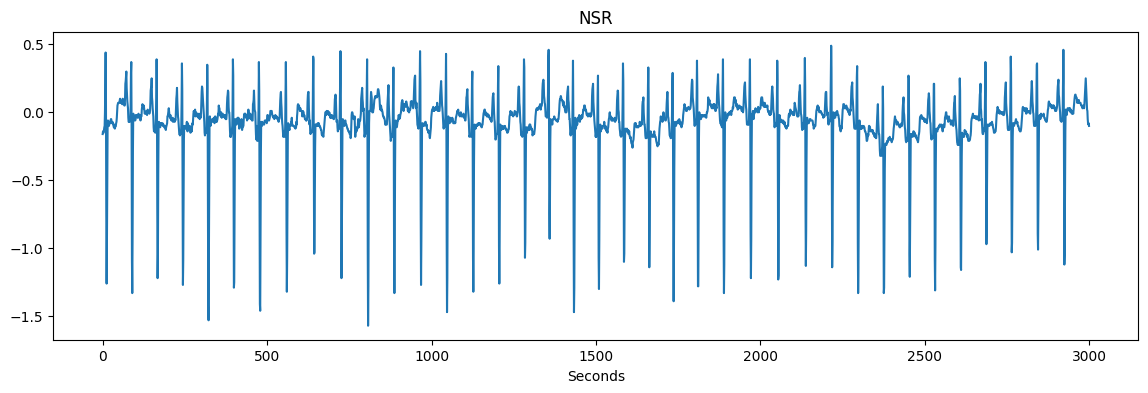

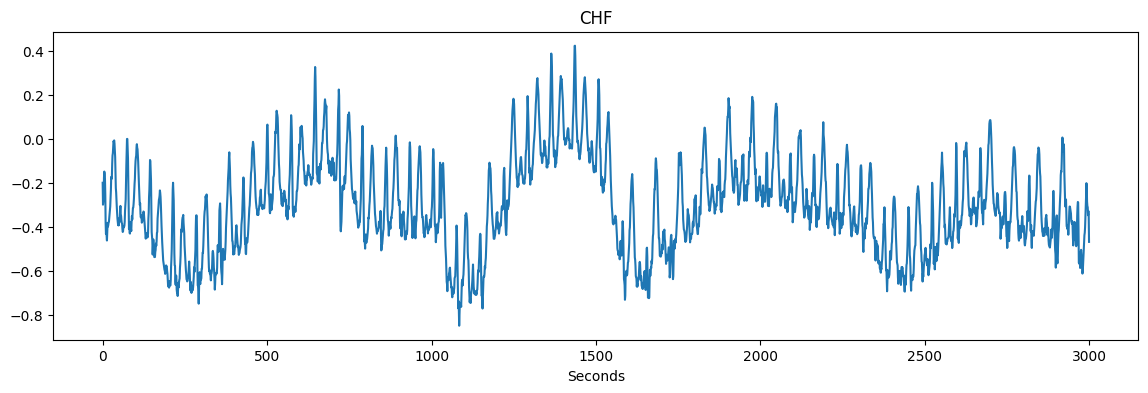

In [7]:
plot_all_data()

## Applying Filters 🚬

### Applying Sin Wave Filter 🌊


In [8]:
import numpy as np

v = np.linspace(0.5 * np.pi, 1.5 * np.pi, 15)
peak_filter = np.sin(v)
def apply_wave_filter(signals):
    return pd.DataFrame(np.correlate(signals, peak_filter, mode='same'))

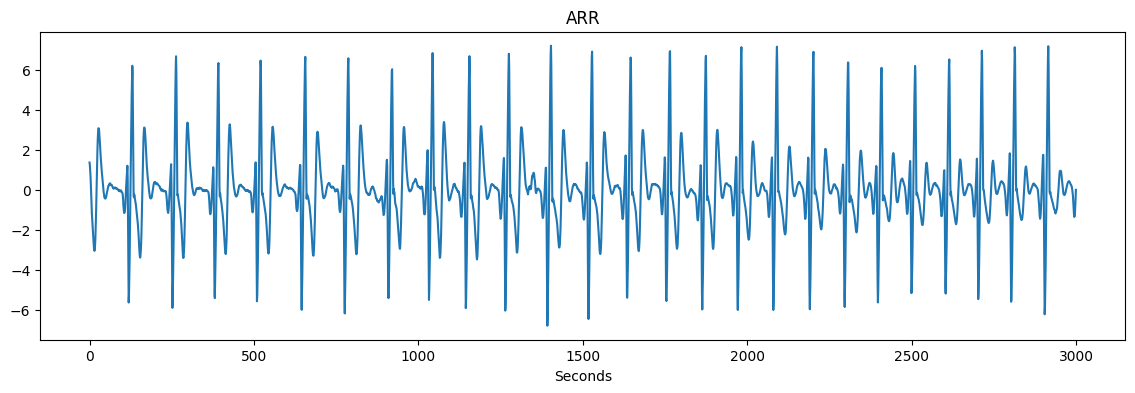

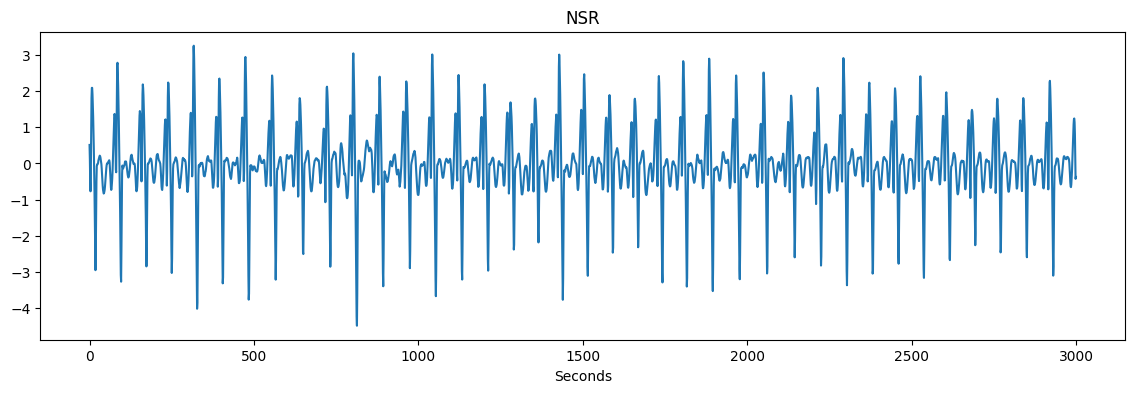

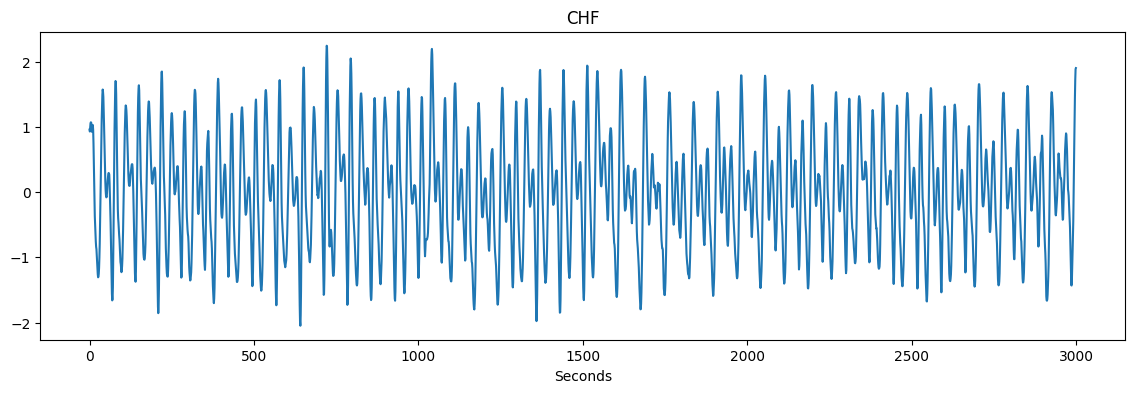

In [9]:
plot_all_data([apply_wave_filter])

### Fourier Transform 🥖 🇫🇷 🌊


In [10]:
from scipy.fft import fft, fftfreq

def fft_filter(signals):
    return pd.DataFrame(np.abs(fft(signals.to_frame())))

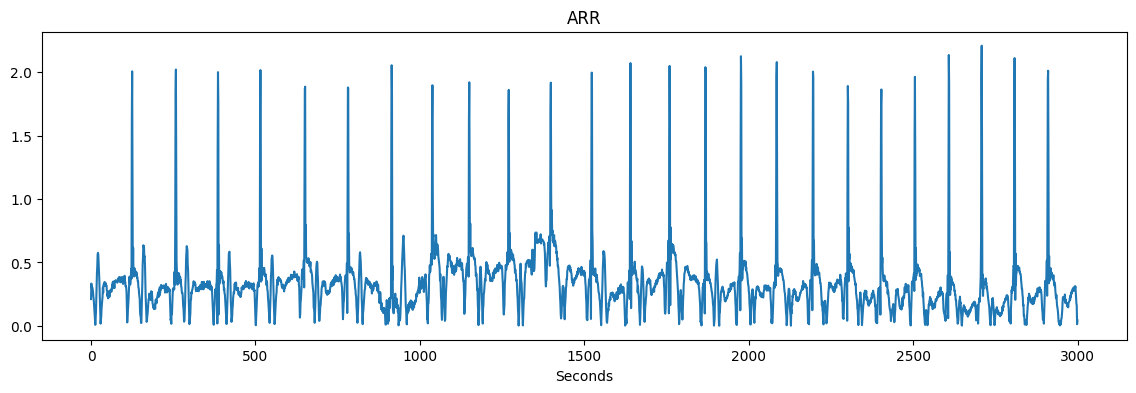

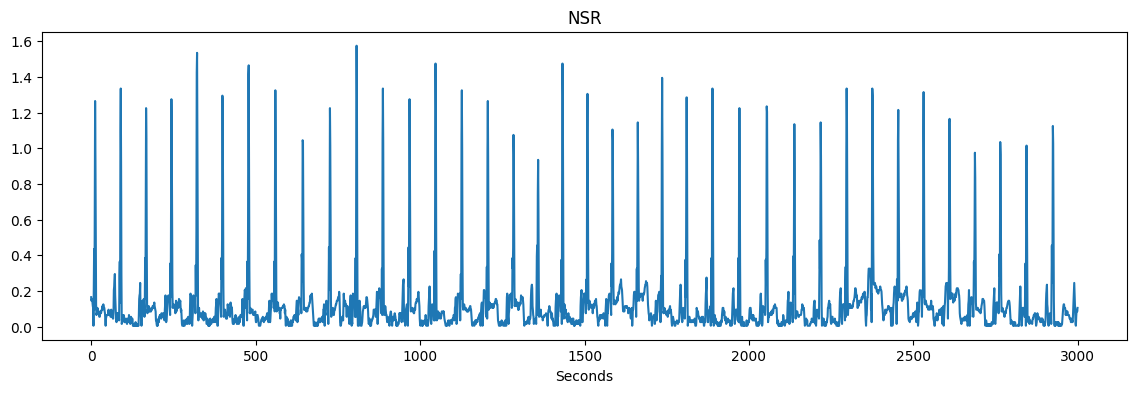

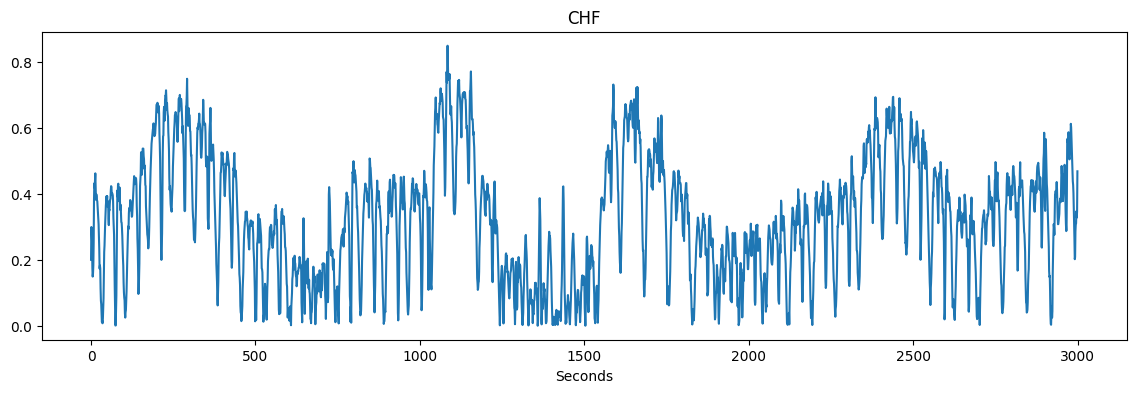

In [11]:
plot_all_data([fft_filter])

### Moving Average 🚚 ⨏


In [12]:
def moving_average(signals, n=100):
    return signals.rolling(n).mean()

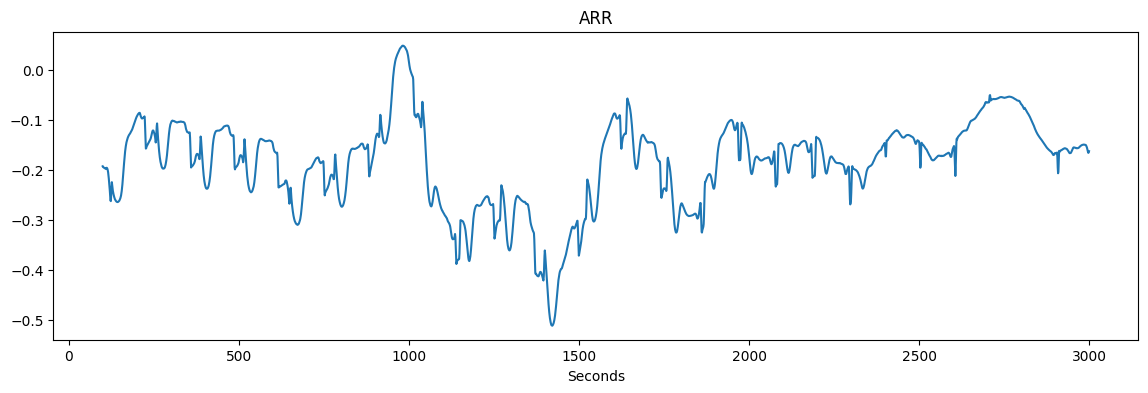

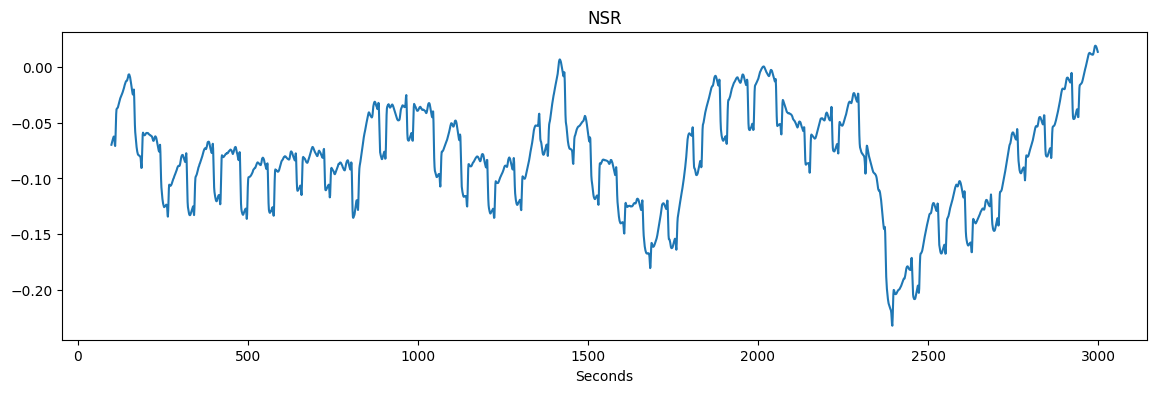

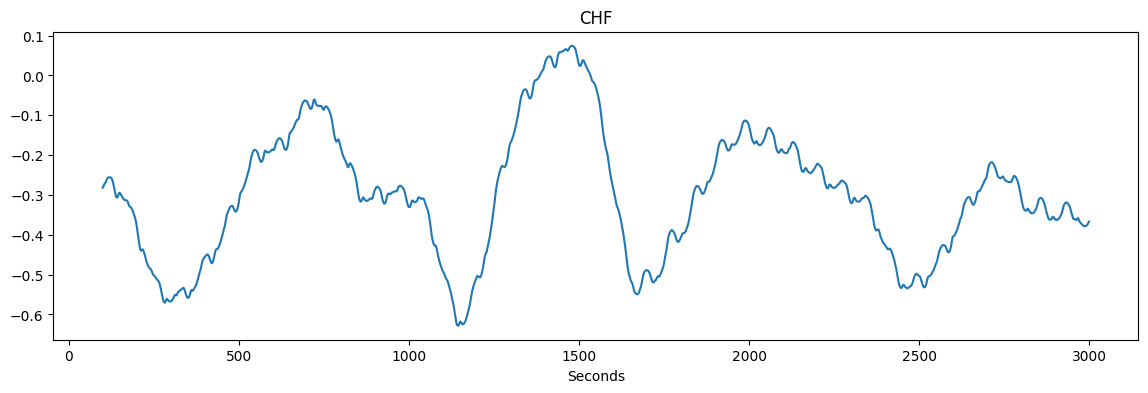

In [13]:
plot_all_data([moving_average])

### Moving Median 🚚 

In [14]:
def moving_median(signals, n=10000):
    return signals.rolling(n).median()

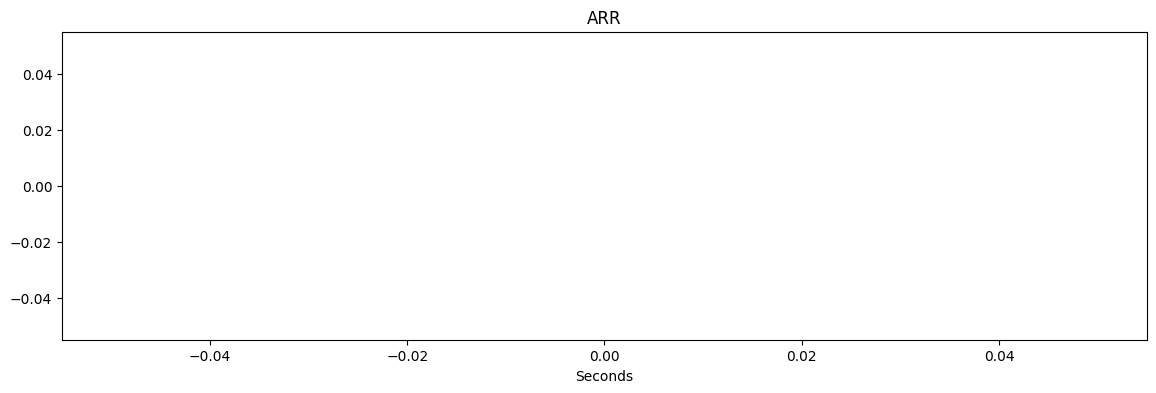

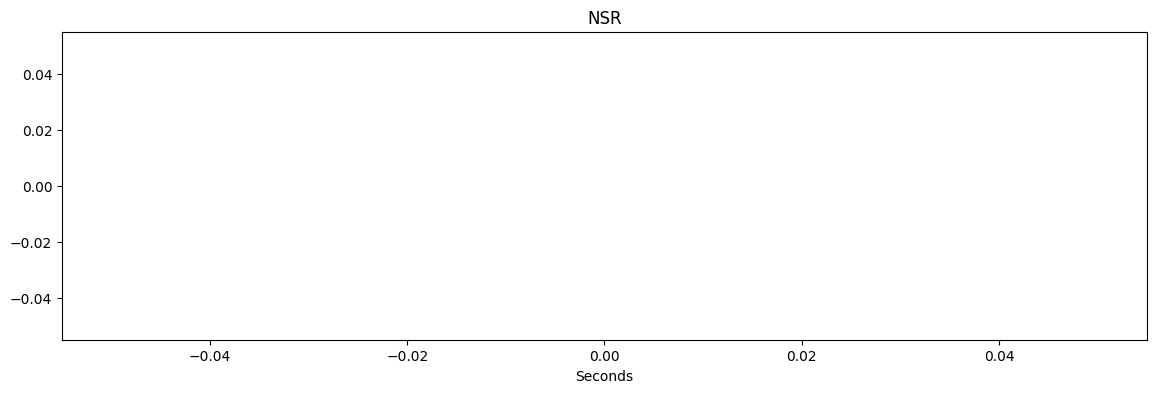

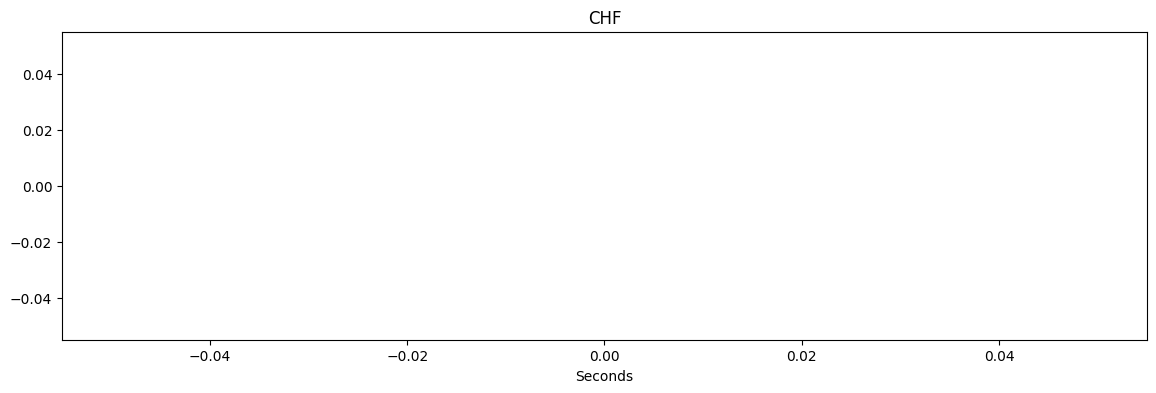

In [15]:
plot_all_data([moving_median])

### Combining Filters 🚬 🤝

#### FFT and Moving Median 🚚 🇫🇷🥖

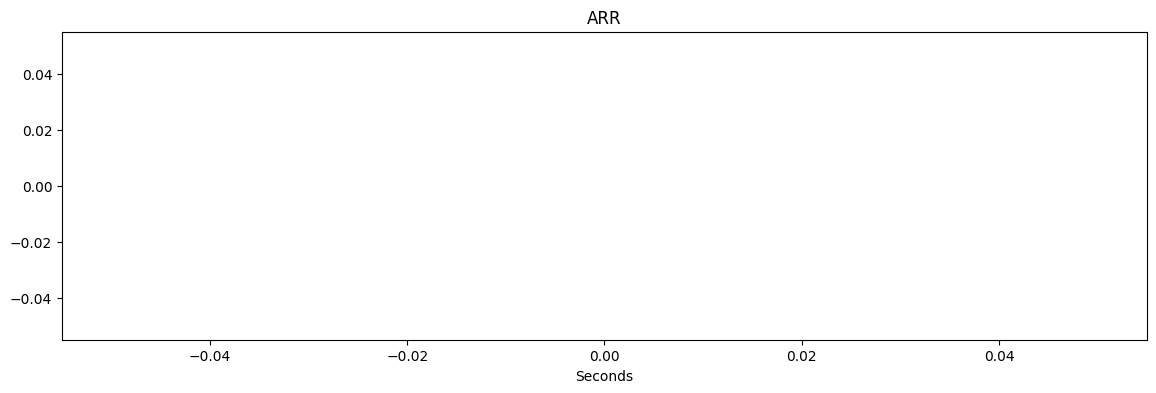

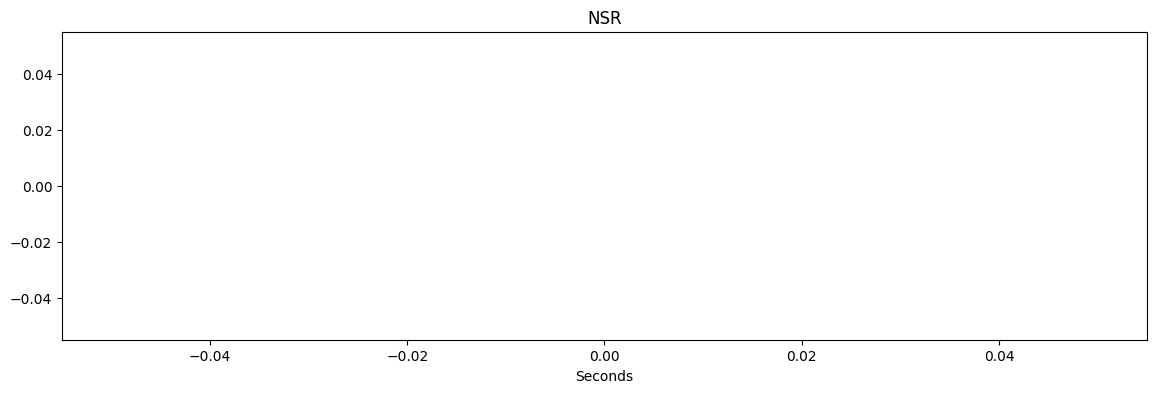

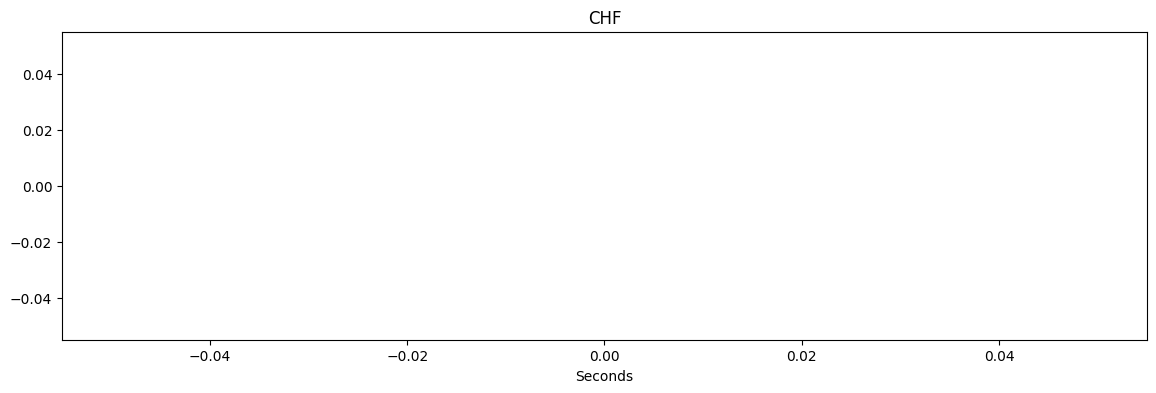

In [16]:
plot_all_data([apply_wave_filter, moving_median])

Looking at the variability of the signals smoothed by `moving median`, we can see some significant patterns regarding the labels:

* NRR Tends to have linear variability, it doesn't smooth goes up or down.
* NRR Maintains an moment plato
* CHF varies much more than ARR
* ARR maintains itself almost invariant throughout time

This means we have two significant dimensions:

1. Variability of the signals throughout time
2. Smoothness of the lines



In [17]:
signal_arr_smoothed, signal_nsr_smoothed, signal_chf_smoothed = signal_arr.copy(), signal_nsr.copy(), signal_chf.copy()

#arr_mm = pd.Series(apply_wave_filter(moving_median(signal_arr_smoothed.SignalData)))
#nsr_mm = pd.Series(apply_wave_filter(moving_median(signal_nsr_smoothed.SignalData)))
#chf_mm = pd.Series(apply_wave_filter(moving_median(signal_chf_smoothed.SignalData)))

arr_mm = pd.Series(moving_median(signal_arr_smoothed.SignalData))
nsr_mm = pd.Series(moving_median(signal_nsr_smoothed.SignalData))
chf_mm = pd.Series(moving_median(signal_chf_smoothed.SignalData))

nsr_mm.unique()


array([    nan, -0.045 , -0.0425, -0.04  , -0.05  , -0.055 , -0.06  ,
       -0.065 ])

In [18]:
def absolute_peak(signals):
    return max(signals.min(), abs(signals.max()))
    
def print_stats(arr_mm, nsr_mm, chf_mm):
    print("variation arr: ", len(arr_mm.unique()))
    print("variation nsr: ", len(nsr_mm.unique()))
    print("variation chf: ", len(chf_mm.unique()))
    print("\n")
    print("absolute peak arr: ", absolute_peak(arr_mm))
    print("absolute peak nsr: ", absolute_peak(nsr_mm))
    print("absolute peak chf: ", absolute_peak(chf_mm))
    print("\n")
    print("iqr arr: ", arr_mm.quantile(q=.75) - arr_mm.quantile(q=.25))
    print("iqr nsr: ", nsr_mm.quantile(q=.75) - nsr_mm.quantile(q=.25))
    print("iqr chf: ", chf_mm.quantile(q=.75) - chf_mm.quantile(q=.25))
    print("\n")
    print("std arr: ", arr_mm.std())
    print("std nsr: ", nsr_mm.std())
    print("std chf: ", chf_mm.std())
    print("\n")
    print("max arr: ", arr_mm.max())
    print("max nsr: ", nsr_mm.max())
    print("max chf: ", chf_mm.max())
    print("\n")
    print("min arr: ", arr_mm.min())
    print("min nsr: ", nsr_mm.min())
    print("min chf: ", chf_mm.min())




In [19]:
print("With moving median")
print_stats(arr_mm, nsr_mm, chf_mm)

With moving median
variation arr:  9238
variation nsr:  8
variation chf:  9515


absolute peak arr:  0.216318485027571
absolute peak nsr:  0.04
absolute peak chf:  0.2695838266878735


iqr arr:  0.050698678291674515
iqr nsr:  0.010000000000000002
iqr chf:  0.030991302860220005


std arr:  0.03871335946828663
std nsr:  0.006609998669730968
std chf:  0.02637018134211231


max arr:  -0.216318485027571
max nsr:  -0.04
max chf:  -0.2695838266878735


min arr:  -0.3477402554265855
min nsr:  -0.065
min chf:  -0.37695130247027697


In [20]:
print("Raw")
print_stats(
    signal_arr.SignalData,
    signal_nsr.SignalData,
    signal_chf.SignalData,
)

Raw
variation arr:  65536
variation nsr:  402
variation chf:  65536


absolute peak arr:  2.40705076027386
absolute peak nsr:  2.065
absolute peak chf:  0.440139017442728


iqr arr:  0.24227652640224248
iqr nsr:  0.12000000000000001
iqr chf:  0.2310437197885345


std arr:  0.35449647578787485
std nsr:  0.23403455593519504
std chf:  0.1895932853516922


max arr:  2.40705076027386
max nsr:  2.065
max chf:  0.440139017442728


min arr:  -1.72089204404105
min nsr:  -1.955
min chf:  -1.10862553180352


## Peaks 🗻


In [21]:
from scipy.signal import find_peaks

In [22]:
arr = signal_arr.copy()
nsr = signal_nsr.copy()
chf = signal_chf.copy()

# arr = arr[1000:6000].reset_index()
# nsr = nsr[1000:6000].reset_index()
# chf = chf[1000:6000].reset_index()

arr_sig = arr.SignalData
nsr_sig = nsr.SignalData
chf_sig = chf.SignalData

# arr_sig = moving_median(arr.SignalData)
# nsr_sig = moving_median(nsr.SignalData)
# chf_sig = moving_median(chf.SignalData)


# arr_sig = fft_filter(arr_sig)[0]
# nsr_sig = fft_filter(nsr_sig)[0]
# chf_sig = fft_filter(chf_sig)[0]

n_average = 100
arr_sig = moving_average(arr_sig, n=n_average)
nsr_sig = moving_average(nsr_sig, n=n_average)
chf_sig = moving_average(chf_sig, n=n_average)

# arr_sig = apply_wave_filter(arr_sig)[0]
# nsr_sig = apply_wave_filter(nsr_sig)[0]
# chf_sig = apply_wave_filter(chf_sig)[0]







In [23]:
distance = 150
p = .4 
w = 0.00000001 

arr_peaks, arr_peaks_props = find_peaks(arr_sig, height=0, distance=distance, prominence=(None, p), width=w)
nsr_peaks, nsr_peaks_props = find_peaks(nsr_sig, height=0, distance=distance, prominence=(None, p), width=w)
chf_peaks, chf_peaks_props = find_peaks(chf_sig, height=0, distance=distance, prominence=(None, p), width=w)

# arr_peaks, arr_peaks_props = find_peaks(arr_sig, height=0, distance=distance)
# nsr_peaks, nsr_peaks_props = find_peaks(nsr_sig, height=0, distance=distance)
# chf_peaks, chf_peaks_props = find_peaks(chf_sig, height=0, distance=distance)


In [24]:
def plot_sig(sig, peaks, title):
    plt.figure(figsize=(14, 4))
    plt.title(title)
    plt.plot(sig)
    plt.plot(peaks, sig[peaks], "x")
    plt.plot(np.zeros_like(sig), "--", color="gray")
    plt.show()

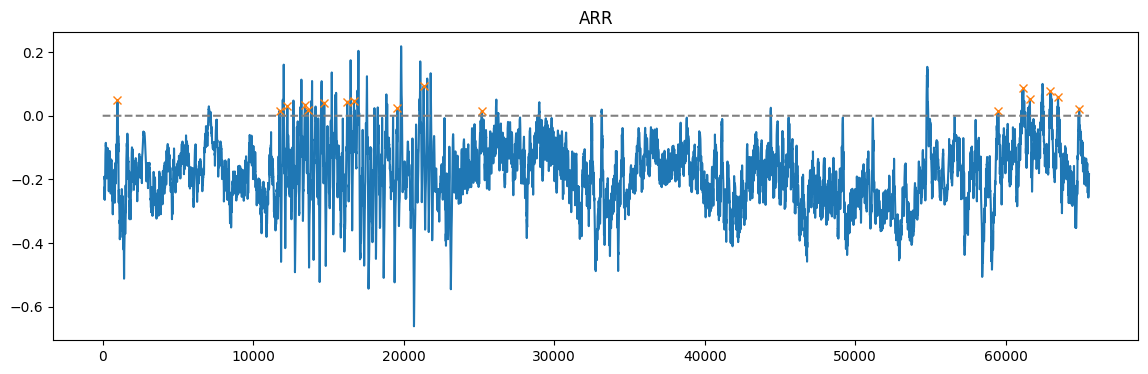

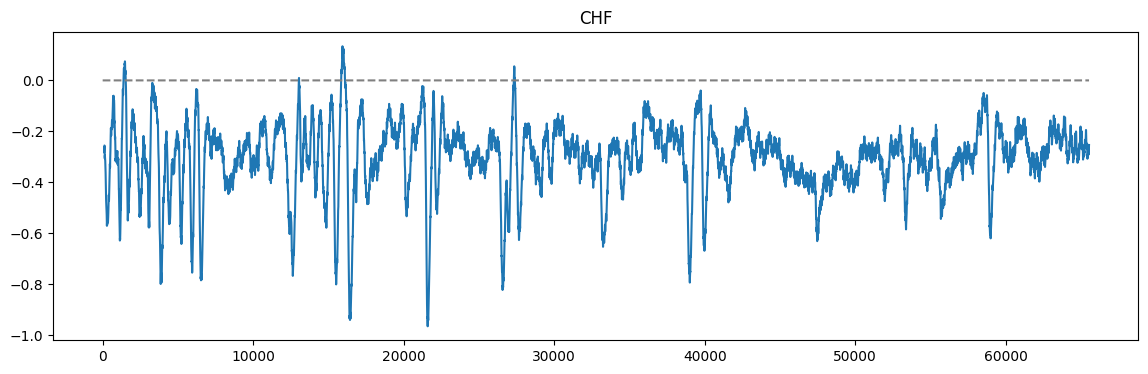

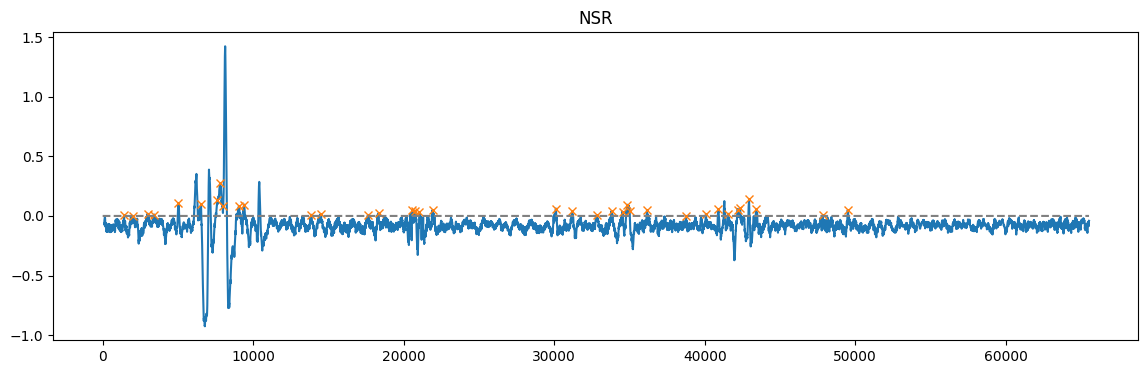

In [25]:
plot_sig(arr_sig, arr_peaks, "ARR")
plot_sig(chf_sig, chf_peaks, "CHF")
plot_sig(nsr_sig, nsr_peaks, "NSR")

In [26]:

def print_info(peak, peak_props, title):
    print("----------------PEAK INFO----------------")
    print(title)
    diff = np.diff(peak)
    print("Total Peaks", len(peak))
    print("----------------DISTANCE INFO----------------")
    print(" mean peak distance: ", np.mean(diff))
    print(" median peak distance: ", np.median(diff))
    print(" standard deviation: ", np.std(diff))
    print(" IQR peak distance: ", np.quantile(diff, q=.75) - np.quantile(diff, q=.25))
    print("----------------Properties INFO----------------")
    print(" max prominence: ", peak_props["prominences"].max()) 
    print(" widths: ", peak_props["widths"].max()) 
    print("----------------END PEAK INFO----------------")
    

In [27]:
print_info(arr_peaks, arr_peaks_props, "ARR Peaks")
#print_info(nsr_peaks, nsr_peaks_props, "NSR Peaks")
print("\n\n")
print_info(chf_peaks, chf_peaks_props, "CHF Peaks")

----------------PEAK INFO----------------
ARR Peaks
Total Peaks 17
----------------DISTANCE INFO----------------
 mean peak distance:  3993.5625
 median peak distance:  1377.5
 standard deviation:  8205.871000149451
 IQR peak distance:  1507.5
----------------Properties INFO----------------
 max prominence:  0.3964484148180216
 widths:  323.2562976369154
----------------END PEAK INFO----------------



----------------PEAK INFO----------------
CHF Peaks
Total Peaks 0
----------------DISTANCE INFO----------------
 mean peak distance:  nan
 median peak distance:  nan
 standard deviation:  nan


/Users/guilhermeleonardonunes/Mestrado/periodo_1/ecg_analise/.venv/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/guilhermeleonardonunes/Mestrado/periodo_1/ecg_analise/.venv/lib/python3.8/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/Users/guilhermeleonardonunes/Mestrado/periodo_1/ecg_analise/.venv/lib/python3.8/site-packages/numpy/core/_methods.py:269: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/guilhermeleonardonunes/Mestrado/periodo_1/ecg_analise/.venv/lib/python3.8/site-packages/numpy/core/_methods.py:226: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/Users/guilhermeleonardonunes/Mestrado/periodo_1/ecg_analise/.venv/lib/python3.8/site-packages/numpy/cor

IndexError: cannot do a non-empty take from an empty axes.

## Let's Create a DataFrame 📈
DataFrame will contain each observation, with applied `moving median` filter with calculated statistics.

In [ ]:
signals = pd.read_csv("transformed_signal_data/labeled_signals.csv")
signals.head()

,Label,1 sec,2 sec,3 sec,4 sec,5 sec,6 sec,7 sec,8 sec,9 sec,...,65527 sec,65528 sec,65529 sec,65530 sec,65531 sec,65532 sec,65533 sec,65534 sec,65535 sec,65536 sec
0,ARR,-0.097857,-0.156881,-0.137816,-0.137177,-0.147684,-0.168522,-0.175891,-0.170236,-0.181131,...,-0.161495,-0.124765,-0.105196,-0.094394,-0.124967,-0.104613,-0.126682,-0.074905,-0.116527,-0.180421
1,ARR,0.119361,0.187559,0.169569,0.178590,0.211824,0.196607,0.072911,0.165885,0.083204,...,-0.141731,-0.121423,-0.113781,-0.087638,-0.097274,-0.089068,-0.105625,-0.097218,-0.123936,-0.106481
2,ARR,-0.024602,-0.036279,-0.035968,-0.030194,-0.045812,-0.093124,-0.091381,-0.128953,-0.112480,...,-0.327886,-0.308444,-0.282376,-0.269384,-0.248776,-0.247613,-0.191715,-0.186142,-0.129985,-0.122356
3,ARR,-0.508309,-0.808009,-0.721684,-0.789720,-0.767678,-0.774352,-0.772501,-0.794323,-0.794939,...,-0.953446,-0.943424,-0.971548,-0.988559,-0.994919,-0.996746,-1.015446,-1.042696,-1.040684,-1.048192
4,ARR,-0.312039,-0.495260,-0.442597,-0.465246,-0.428401,-0.444373,-0.417601,-0.453342,-0.429223,...,0.392087,0.434705,0.523518,0.592920,0.663007,0.743777,0.809435,0.822494,0.787239,0.684293


In [ ]:
signals_2 = signals.copy()
signals_stats = signals_2.pop("Label")
signals_stats = signals_stats.to_frame()
signals_stats.head()

signals_stats["variation"] = None
signals_stats["absolute_peak"] = None
signals_stats["iqr"] = None

signals_stats
for i in range(0, 161):
    sig = signals.loc[i][1:].values
    medians = moving_median(pd.Series(sig))
    #medians = pd.Series(sig)
    signals_stats.loc[i, "variation"] = len(medians.unique())
    signals_stats.loc[i, "absolute_peak"] = max(medians.min(), abs(medians.max()))
    signals_stats.loc[i, "iqr"] = medians.quantile(q=.75) - medians.quantile(q=.25)
    signals_stats.loc[i, "min"] = medians.min()
    signals_stats.loc[i, "max"] = medians.max()
    signals_stats.loc[i, "std"] = medians.std()
    
# 
# medians = moving_median(pd.Series(sig))

# medians

KeyboardInterrupt: 

In [ ]:
signals_stats[signals_stats.Label == "NSR"].head()

,Label,variation,absolute_peak,iqr,min,max,std
126,NSR,22,0.115,0.02,-0.215,-0.115,0.015665
127,NSR,26,0.005,0.01,-0.115,0.005,0.014030
128,NSR,18,0.055,0.02,-0.135,-0.055,0.013827
129,NSR,44,0.015,0.04,-0.195,0.015,0.033517
130,NSR,69,0.045,0.03,-0.175,0.045,0.030749


In [ ]:
import pandas as pd
pd.plotting.register_matplotlib_converters()
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

<Axes: xlabel='max', ylabel='variation'>

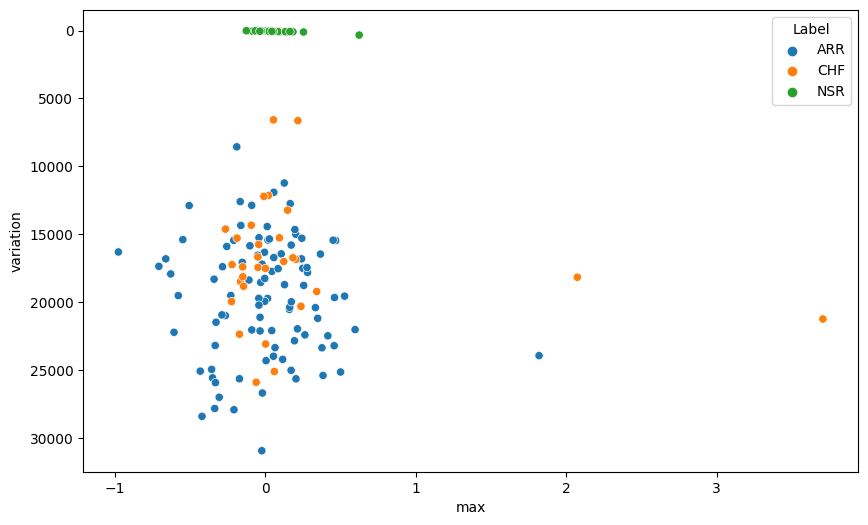

In [ ]:
plt.figure(figsize=(10, 6))

sns.scatterplot(
    x=signals_stats["max"],
    y=signals_stats["variation"],
    hue=signals_stats["Label"],
)

In [ ]:

features = ["absolute_peak", "iqr", "variation", "min", "max"]
X = signals_stats.copy()
y = X.pop("Label")
X = X.loc[:160, features]

X_scaled = (X - X.mean(axis=0)) / X.std(axis=0)
X_scaled.head()

,absolute_peak,iqr,variation,min,max
0,0.060759,-0.812935,0.116855,0.08457,-0.687406
1,-0.113639,-0.457972,-0.718927,-0.08343,-0.537665
2,-0.565533,0.71586,0.553039,-0.073033,-0.074462
3,0.829905,0.233137,0.059298,-1.790225,-1.347804
4,-0.18459,0.881091,0.644676,-0.198946,0.25262


In [ ]:
from sklearn.decomposition import PCA

pca = PCA(n_components=1)
X_pca = pca.fit_transform(X_scaled)

# Convert to dataframe
component_names = [f"PC{i+1}" for i in range(X_pca.shape[1])]
X_pca = pd.DataFrame(X_pca, columns=component_names)

X_pca.head()

,PC1
0,-0.634651
1,-0.715171
2,0.294994
3,0.895181
4,0.783237
